In [2]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import DatasetFolder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomObjectDetectionModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomObjectDetectionModel, self).__init__()
        # Define convolutional layers for feature extraction
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # Define max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Define fully connected layers for classification and bounding box regression
        self.fc1 = nn.Linear(256 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.fc3 = nn.Linear(512, 4)

    def forward(self, x):
        # Apply convolutional layers with ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        # Flatten the feature maps
        x = x.view(-1, 256 * 28 * 28)

        # Apply fully connected layers for classification
        x = F.relu(self.fc1(x))
        cls_output = F.softmax(self.fc2(x), dim=1)  # Apply softmax activation

        # Apply fully connected layers for bounding box regression
        reg_output = self.fc3(x)

        return cls_output, reg_output


In [4]:
# Define input shape of images
input_shape = (228, 228)
num_classes = 3  # Number of output classes: fire and smoke

# custom object detection model
object_detection_model = CustomObjectDetectionModel(num_classes)


In [6]:
print(object_detection_model)

CustomObjectDetectionModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
  (fc3): Linear(in_features=512, out_features=4, bias=True)
)


In [7]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, root_dir, image_ext=".jpg", label_ext=".txt", transform=None):
        self.root_dir = root_dir
        self.image_ext = image_ext
        self.label_ext = label_ext
        self.transform = transform
        print(root_dir)
        self.image_files = [file for file in os.listdir(root_dir + "/images") if file.endswith(image_ext)]
        self.label_files = [file for file in os.listdir(root_dir+ "/labels") if file.endswith(label_ext)]
        print("Number of image files:", len(self.image_files))
        print("Number of label files:", len(self.label_files))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir+ "/images", self.image_files[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        # Load corresponding label file based on image file
        label_name = os.path.join(self.root_dir+ "/labels", self.label_files[idx])
        # Implement logic to load and preprocess label data
        with open(label_name, 'r') as file:
            label_data = file.read().strip()  # Read and preprocess label data as needed


        return image, label_data

In [8]:
from torchvision import transforms

# Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize(input_shape[:2]),
    transforms.ToTensor(),
])

# Define training dataset
train_dataset = CustomDataset(root_dir='/content/YOLOv8-Fire-and-Smoke-Detection/datasets/fire-8/train',
                              image_ext=".jpg",
                              label_ext=".txt",
                              transform=data_transforms)

# Define data loaders for training
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define testing dataset
test_dataset = CustomDataset(root_dir='/content/YOLOv8-Fire-and-Smoke-Detection/datasets/fire-8/test',
                             image_ext=".jpg",
                             label_ext=".txt",
                             transform=data_transforms)

# Define data loader for testing
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


/content/YOLOv8-Fire-and-Smoke-Detection/datasets/fire-8/train
Number of image files: 877
Number of label files: 877
/content/YOLOv8-Fire-and-Smoke-Detection/datasets/fire-8/test
Number of image files: 55
Number of label files: 55


In [9]:
#loss function and optimizer
optimizer = optim.Adam(object_detection_model.parameters(),lr = 0.01)

In [10]:
!pip install tqdm

In [11]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [12]:
import torch.nn as nn

# Define the classification loss criterion
criterion_cls = nn.CrossEntropyLoss()

# Define the regression loss criterion
criterion_reg = nn.MSELoss()


In [14]:
from tqdm import tqdm
import os
import torch

epochs = 30
checkpoint_dir = '/content/drive/MyDrive/chk'
os.makedirs(checkpoint_dir, exist_ok=True)

# Load the model checkpoint
checkpoint = torch.load("/content/drive/MyDrive/chk/object_detection_model_epoch_9.pth")

# Load the model state dictionary
object_detection_model.load_state_dict(checkpoint)

epoch_loss_history = []

for epoch in range(epochs):
    train_loader_iterator = iter(train_loader)
    object_detection_model.train()
    running_loss = 0.0

    progress_bar = tqdm(enumerate(train_loader_iterator), total=(len(train_loader)-1))

    for batch_idx, (inputs, labels_tuple) in progress_bar:
        if batch_idx == 27:
            continue

        optimizer.zero_grad()

        cls_output, reg_output = object_detection_model(inputs)

        for i in range(len(cls_output)):
            label_tensor = labels_tuple[i]

            try:
                if isinstance(label_tensor, str):
                    label_values = label_tensor.split(' ')
                else:
                    label_values = [str(val.item()) for val in label_tensor.flatten()]

                if label_values:
                    class_label = int(float(label_values[0]))
                    bbox_values = [float(val) for val in label_values[1:] if val != '\n']

                    labels_tensor = torch.tensor([class_label] + bbox_values, dtype=torch.float32)

                    cls_loss = criterion_cls(cls_output[i:i+1], torch.tensor([class_label]))
                    reg_loss = criterion_reg(reg_output[i:i+1], labels_tensor[1:].unsqueeze(0))

                    loss = cls_loss + reg_loss

                    loss.backward(retain_graph=True)

                    running_loss += loss.item()

            except ValueError as e:
                continue

        optimizer.step()

        progress_bar.set_description(f'Epoch [{epoch + 1}/{epochs}], Batch [{batch_idx + 1}/{(len(train_loader)-1)}]')

    epoch_loss = running_loss / (len(train_loader) -1)
    epoch_loss_history.append(epoch_loss)

    if (epoch + 1) % 20 == 0:  # Save checkpoint and loss history every 20 epochs
        # Save model checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f'object_detection_model_epoch_{epoch+1}.pth')
        torch.save(object_detection_model.state_dict(), checkpoint_path)

        # Save epoch loss history to a file
        history_file = os.path.join(checkpoint_dir, f'epoch_loss_history_epoch_{epoch+1}.txt')
        with open(history_file, 'w') as file:
            for loss in epoch_loss_history:
                file.write(f'{loss}\n')

    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}')

# Save final trained model
final_model_path = os.path.join(checkpoint_dir, 'object_detection_model_final.pth')
torch.save(object_detection_model.state_dict(), final_model_path)


Epoch [1/100], Batch [27/27]: : 28it [02:06,  4.53s/it]
Epoch [1/100], Loss: 0.9998
Epoch [2/100], Batch [27/27]: : 28it [02:02,  4.39s/it]
Epoch [2/100], Loss: 0.9935
Epoch [3/100], Batch [27/27]: : 28it [01:55,  4.12s/it]
Epoch [3/100], Loss: 0.9935
Epoch [4/100], Batch [27/27]: : 28it [01:51,  3.99s/it]
Epoch [4/100], Loss: 0.9935
Epoch [5/100], Batch [27/27]: : 28it [01:53,  4.05s/it]
Epoch [5/100], Loss: 0.9931
Epoch [6/100], Batch [27/27]: : 28it [01:59,  4.26s/it]
Epoch [6/100], Loss: 0.8799
Epoch [7/100], Batch [27/27]: : 28it [01:53,  4.05s/it]
Epoch [7/100], Loss: 0.8668
Epoch [8/100], Batch [27/27]: : 28it [01:58,  4.24s/it]
Epoch [8/100], Loss: 0.8599
Epoch [9/100], Batch [27/27]: : 28it [01:53,  4.06s/it]
Epoch [9/100], Loss: 0.8578
Epoch [10/100], Batch [27/27]: : 28it [01:55,  4.13s/it]
Epoch [10/100], Loss: 0.8403
Epoch [11/100], Batch [27/27]: : 28it [01:56,  4.14s/it]
Epoch [11/100], Loss: 0.8309
Epoch [12/100], Batch [27/27]: : 28it [01:49,  3.91s/it]
Epoch [12/100],

In [16]:
import numpy as np

# Set the model to evaluation mode
object_detection_model.eval()

# Lists to store predictions and ground truth labels
all_predictions = []
all_labels = []


for inputs,labels_tuple in test_loader:
  print(inputs.shape)

# Iterate over the test dataset
for inputs, labels_tuple in test_loader:
    # Forward pass
    cls_output, _ = object_detection_model(inputs)

    # Convert class probabilities to predicted labels
    _, predicted = torch.max(cls_output, 1)

    # Convert tensor to numpy array and append to the list
    all_predictions.extend(predicted.numpy())

    # Extract class labels from labels_tuple
    labels = [int(label.split()[0]) for label in labels_tuple]

    # Append ground truth labels to the list
    all_labels.extend(labels)
    break

# Convert lists to numpy arrays for ease of computation
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

labels = all_labels[:8]
print(labels.size)
print(all_predictions.size)

# Compute evaluation metrics
accuracy = accuracy_score(labels, all_predictions)
precision = precision_score(labels, all_predictions, average='macro')
recall = recall_score(labels, all_predictions, average='macro')
f1 = f1_score(labels, all_predictions, average='macro')

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.5000
Precision: 0.2500
Recall: 0.5000
F1 Score: 0.3333


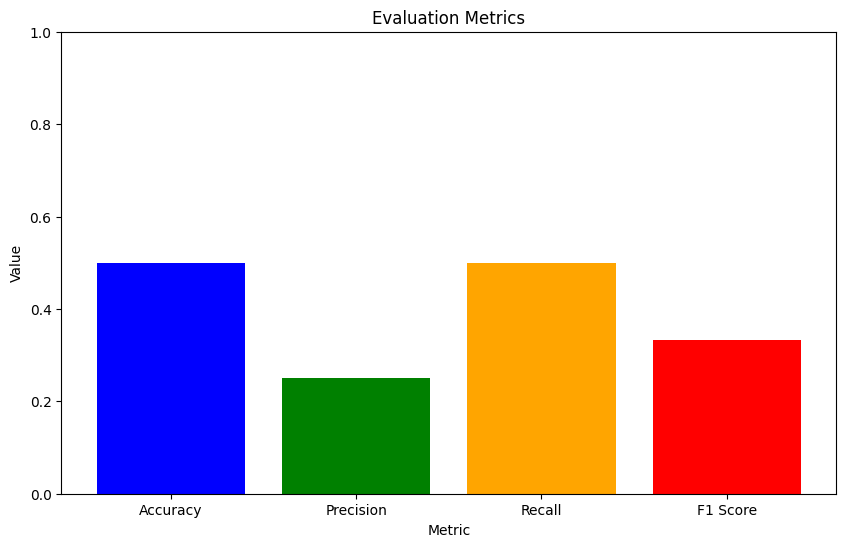

In [ ]:
import matplotlib.pyplot as plt

# Define evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

# Plot bar graph
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
plt.title('Evaluation Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for better visualization
plt.show()
